# Code to transmit the Data to the FPGA

In [1]:
import serial.tools.list_ports
import matplotlib.pyplot as plt
ports = serial.tools.list_ports.comports()
%matplotlib widget

for port, desc, hwid in sorted(ports):
        print("{}: {} [{}]".format(port, desc, hwid))

COM4: Standard Serial over Bluetooth link (COM4) [BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_LOCALMFG&0002\8&2907864F&0&E8EECC6F76A6_C00000000]
COM5: Standard Serial over Bluetooth link (COM5) [BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_LOCALMFG&0000\8&2907864F&0&000000000000_00000000]
COM9: USB Serial Port (COM9) [USB VID:PID=0403:6010 SER=210183BB7E92B]


loading img

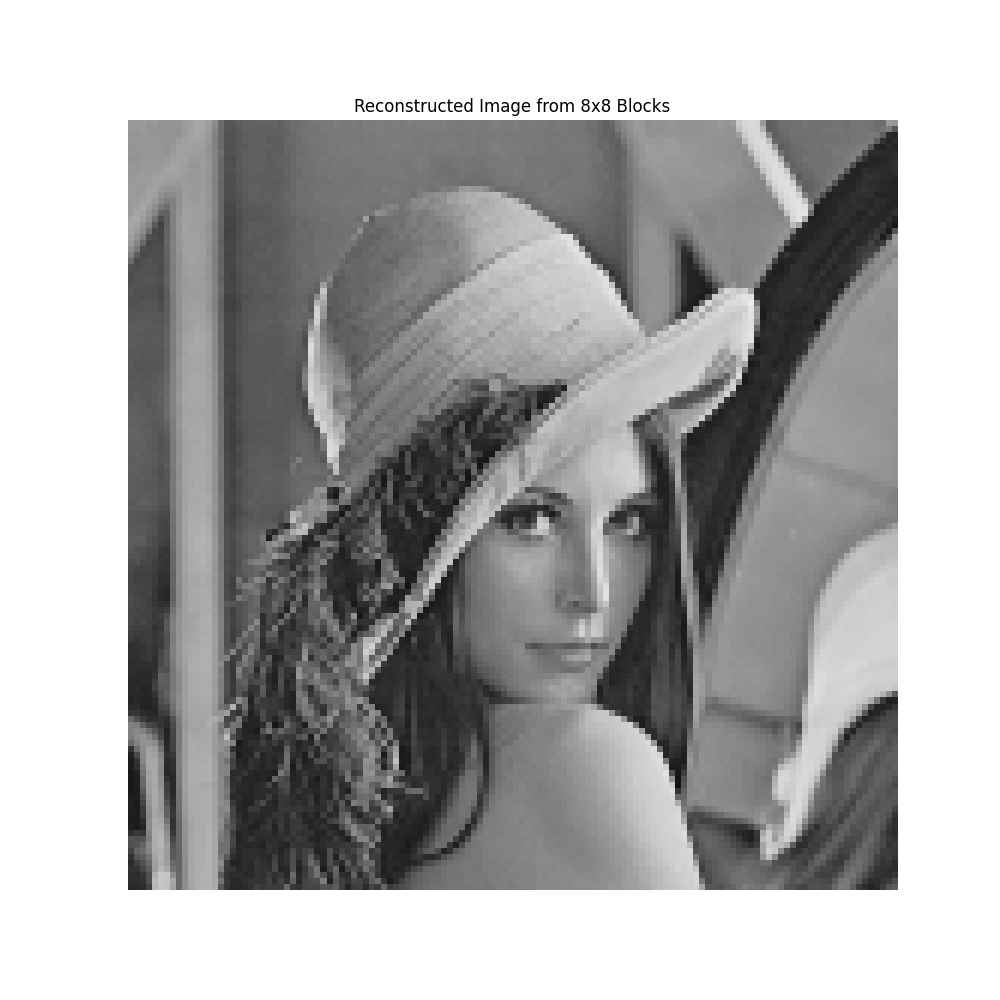

In [2]:
import numpy as np
import cv2

# Load the grayscale image
# im = cv2.imread("lenna_128x128.png", cv2.IMREAD_GRAYSCALE)

# # Write pixel values as 8-bit binary
# with open('image.txt', 'w') as f:
#     for i in im.reshape(-1, 1)[:, 0]:
#         f.write(f"{i:08b}\n")  # Convert to 8-bit binary

# arr = []
# with open('image.txt') as f:
#     for pixel in f.readlines():
#         arr.append(int(pixel, 2))
# plt.figure(figsize=(15,15))
# plt.imshow(np.array(arr).reshape((128,128)),cmap='gray',interpolation=None,vmax=255,vmin=0)
# ogimg = np.array(arr).reshape((128,128))


im = cv2.imread("lenna_128x128.png", cv2.IMREAD_GRAYSCALE)
block_size = 8
height, width = im.shape

with open('image.txt', 'w') as f:
    for row in range(0, height, block_size):
        for col in range(0, width, block_size):
            block = im[row:row+block_size, col:col+block_size]
            flat_block = block.flatten()
            for pixel in flat_block:
                f.write(f"{pixel:08b}\n")  

arr = []
with open('image.txt') as f:
    for pixel in f.readlines():
        arr.append(int(pixel.strip(), 2))

reconstructed = np.zeros_like(im)
index = 0
for row in range(0, height, block_size):
    for col in range(0, width, block_size):
        block = np.array(arr[index:index+64]).reshape((8, 8))
        reconstructed[row:row+8, col:col+8] = block
        index += 64
ogimg = reconstructed
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
plt.title("Reconstructed Image from 8x8 Blocks")
plt.axis('off')
plt.show()

Connecting with the COM ports

In [3]:
import serial
import struct
from time import sleep
# Setup serial port
# ComPort = serial.Serial('COM4', baudrate=9600, bytesize=8, parity='N', stopbits=1)
ComPort = serial.Serial('COM9', baudrate=9600, bytesize=8, parity='N', stopbits=1)
# if not ComPort.isOpen():
#     ComPort.open()
ComPort.flushOutput()
ComPort.flushInput()


To send data (img.txt) to board - __ensure read switch is on__

In [4]:
ComPort.flushOutput()
ComPort.flushInput()


# Read pixel values
with open(r'image.txt' , "r") as f:
    lines = f.readlines()
# lines = ['0']*128*128

assert len(lines) == 128 * 128, "Image.txt does not contain 16384 pixels!"

# Transmit to FPGA
lines_to_transmit = lines
  # Only transmit the first 64 pixels (ensure the same in dct module)
for i, line in enumerate(lines_to_transmit):
    binary_string = line.strip().zfill(8)       # Pad to 8 bits
    pixel = int(binary_string, 2)
    ComPort.write(struct.pack('B', pixel))
    print(i,f"{pixel}")
    sleep(0.002)  # Safe timing

print("✅ Completed transmission to FPGA.")


0 155
1 153
2 155
3 152
4 153
5 149
6 148
7 148
8 153
9 152
10 153
11 147
12 149
13 146
14 148
15 147
16 150
17 147
18 151
19 150
20 149
21 148
22 147
23 147
24 151
25 150
26 150
27 149
28 150
29 149
30 147
31 148
32 149
33 149
34 150
35 150
36 150
37 149
38 146
39 152
40 150
41 148
42 150
43 151
44 151
45 149
46 146
47 154
48 148
49 148
50 152
51 151
52 151
53 150
54 152
55 159
56 151
57 151
58 152
59 152
60 152
61 154
62 157
63 162
64 149
65 156
66 161
67 167
68 166
69 158
70 141
71 108
72 147
73 154
74 162
75 167
76 165
77 156
78 135
79 107
80 147
81 157
82 163
83 166
84 164
85 153
86 131
87 107
88 155
89 161
90 164
91 162
92 159
93 150
94 129
95 105
96 159
97 161
98 160
99 158
100 158
101 147
102 131
103 106
104 161
105 158
106 158
107 157
108 154
109 147
110 132
111 112
112 161
113 161
114 155
115 153
116 154
117 149
118 132
119 104
120 162
121 158
122 152
123 150
124 156
125 152
126 131
127 105
128 85
129 87
130 94
131 96
132 98
133 99
134 99
135 100
136 83
137 84
138 89
139 98
1

Code to generate statements for sim

In [27]:
with open(r'image.txt', "r") as f:
    lines = f.readlines()

# Clean and convert each binary string to integer
pixels = [int(line.strip(), 2) for line in lines[0:64] if line.strip()]

# Generate uart_send_byte lines
for pixel in pixels:
    print(f"uart_send_byte(8'h{pixel:02X});", end='')

uart_send_byte(8'h9B);uart_send_byte(8'h99);uart_send_byte(8'h9B);uart_send_byte(8'h98);uart_send_byte(8'h99);uart_send_byte(8'h95);uart_send_byte(8'h94);uart_send_byte(8'h94);uart_send_byte(8'h99);uart_send_byte(8'h98);uart_send_byte(8'h99);uart_send_byte(8'h93);uart_send_byte(8'h95);uart_send_byte(8'h92);uart_send_byte(8'h94);uart_send_byte(8'h93);uart_send_byte(8'h96);uart_send_byte(8'h93);uart_send_byte(8'h97);uart_send_byte(8'h96);uart_send_byte(8'h95);uart_send_byte(8'h94);uart_send_byte(8'h93);uart_send_byte(8'h93);uart_send_byte(8'h97);uart_send_byte(8'h96);uart_send_byte(8'h96);uart_send_byte(8'h95);uart_send_byte(8'h96);uart_send_byte(8'h95);uart_send_byte(8'h93);uart_send_byte(8'h94);uart_send_byte(8'h95);uart_send_byte(8'h95);uart_send_byte(8'h96);uart_send_byte(8'h96);uart_send_byte(8'h96);uart_send_byte(8'h95);uart_send_byte(8'h92);uart_send_byte(8'h98);uart_send_byte(8'h96);uart_send_byte(8'h94);uart_send_byte(8'h96);uart_send_byte(8'h97);uart_send_byte(8'h97);uart_send_

### Code to receive the Data from the FPGA for q8.8

0:  155
1:  153
2:  155
3:  152
4:  153
5:  149
6:  148
7:  148
8:  153
9:  152
10:  153
11:  147
12:  149
13:  146
14:  148
15:  147
16:  150
17:  147
18:  151
19:  150
20:  149
21:  148
22:  147
23:  147
24:  151
25:  150
26:  150
27:  149
28:  150
29:  149
30:  147
31:  148
32:  149
33:  149
34:  150
35:  150
36:  150
37:  149
38:  146
39:  152
40:  150
41:  148
42:  150
43:  151
44:  151
45:  149
46:  146
47:  154
48:  148
49:  148
50:  152
51:  151
52:  151
53:  150
54:  152
55:  159
56:  151
57:  151
58:  152
59:  152
60:  152
61:  154
62:  157
63:  162
64:  149
65:  156
66:  161
67:  167
68:  166
69:  158
70:  141
71:  108
72:  147
73:  154
74:  162
75:  167
76:  165
77:  156
78:  135
79:  107
80:  147
81:  157
82:  163
83:  166
84:  164
85:  153
86:  131
87:  107
88:  155
89:  161
90:  164
91:  162
92:  159
93:  150
94:  129
95:  105
96:  159
97:  161
98:  160
99:  158
100:  158
101:  147
102:  131
103:  106
104:  161
105:  158
106:  158
107:  157
108:  154
109:  147
110:  132


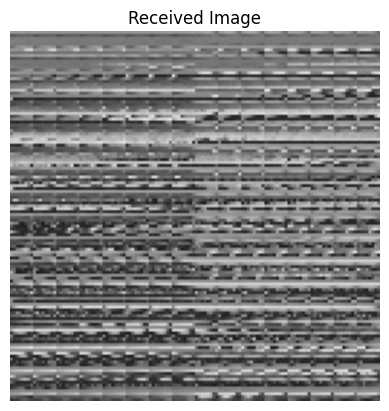

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import serial
import struct
from time import sleep

# === Setup serial port ===
# ComPort = serial.Serial('COM4', baudrate=9600, bytesize=8, parity='N', stopbits=1)
ComPort.flushInput()
ComPort.flushOutput()

# === Image Receive Buffer ===
arr = []
a2 = []
# === Receive 16384 bytes (128x128) ===
for i in range(16384):
    byte = ComPort.read(size=1)
    a2.append(byte)
    pixel = int.from_bytes(byte, byteorder='little', signed=False)
    arr.append(pixel)
    print(f"{i}:  {pixel}")
    sleep(0.001)  # Prevent UART overflow

print("✅ Completed reception")
print("Total pixels received:", len(arr))

# === Save to file ===
with open("obtained_image_iter2_noise.txt", 'w') as f:
    for idx, pixel in enumerate(arr):
        f.write(f"{pixel}\n")

# === Display image ===
if len(arr) == 128 * 128:
    img = np.array(arr, dtype=np.uint8).reshape((128, 128))
    plt.imshow(img, cmap='gray',interpolation=None,vmax=255,vmin=0)
    plt.title("Received Image")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ Error: Did not receive exactly 128x128 pixels.")


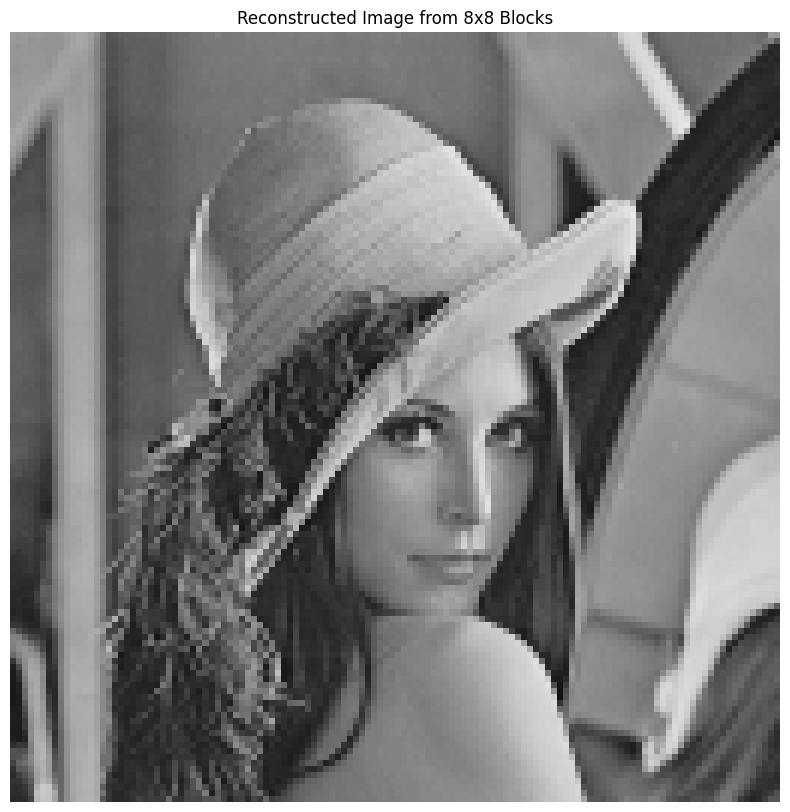

In [ ]:
reconstructed = np.zeros_like(im)
index = 0
for row in range(0, height, block_size):
    for col in range(0, width, block_size):
        block = np.array(arr[index:index+64]).reshape((8, 8))
        reconstructed[row:row+8, col:col+8] = block
        index += 64

plt.figure(figsize=(10, 10))
plt.imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
plt.title("Reconstructed Image from 8x8 Blocks")
plt.axis('off')
plt.show()

### Code to receive the Data from the FPGA for q8.8

__First run this block__

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import serial
import struct
from time import sleep

sleep_time = 0.002

ComPort.flushInput()
ComPort.flushOutput()

# === Image Receive Buffer (binary representation) ===
binary_data = []

# === Receive 16384 bytes (128x128 image) ===
for i in range(2*16384):
    byte = ComPort.read(size=1)
    binary_string = format(byte[0], '08b')  # Convert to 8-bit binary string
    binary_data.append(binary_string)
    print(f"{i}:  {binary_string}")
    sleep(sleep_time)  # Prevent UART overflow

print("✅ Completed reception")
print("Total bytes received:", len(binary_data))

# === Save to file ===
with open("obtained_image_binary.txt", 'w') as f:
    for b in binary_data:
        f.write(f"{b}\n")

0:  01010101
1:  01010101
2:  01010101
3:  01010101
4:  01010101
5:  01010101
6:  10011011
7:  10011001
8:  10011011
9:  10011000
10:  10011001
11:  10010101
12:  10010100
13:  10010100
14:  10011001
15:  10011000
16:  10011001
17:  10010011
18:  10010101
19:  10010010
20:  10010100
21:  10010011
22:  10010110
23:  10010011
24:  10010111
25:  10010110
26:  10010101
27:  10010100
28:  10010011
29:  10010011
30:  10010111
31:  10010110
32:  10010110
33:  10010101
34:  10010110
35:  10010101
36:  10010011
37:  10010100
38:  10010101
39:  10010101
40:  10010110
41:  10010110
42:  10010110
43:  10010101
44:  10010010
45:  10011000
46:  10010110
47:  10010100
48:  10010110
49:  10010111
50:  10010111
51:  10010101
52:  10010010
53:  10011010
54:  10010100
55:  10010100
56:  10011000
57:  10010111
58:  10010111
59:  10010110
60:  10011000
61:  10011111
62:  10010111
63:  10010111
64:  10100010
65:  10100010
66:  10100010
67:  10100010
68:  10100010
69:  10100010
70:  10010101
71:  10011100
72

Concatenate the two BRAM values

In [6]:
# d2 = []
# for i in range(16384):
#     d2.append(binary_data[2*i]+binary_data[2*i+1])

d2 = []
for i in range(16384):
    d2.append(binary_data[i]+binary_data[i+16384])

Convert to floating point numbers

In [10]:
def q11_5_to_float(index, binary_str: str) -> float:
    # Convert binary string to signed 16-bit integer
    value = int(binary_str, 2) / 2**8

    # if value & (1 << 15):  # if the sign bit is set
    #     value -= 1 << 16   # convert to negative using two's complement
    #     print(f"Negative value detected at {index}: {value}")

    # return value / 32.0  # divide by 2^5
    return value   # divide by 2^5



d3 = [q11_5_to_float(i, val) for i, val in enumerate(d2)]
d3 = np.array(d3)
d3.shape

(16384,)

reshaping into blocks

In [11]:
arr = d3 
reconstructed = np.zeros(im.shape)
index = 0
# height, width = 8, 8
for row in range(0, height, block_size):
    for col in range(0, width, block_size):
        block = np.array(arr[index:index+64]).reshape((8, 8))
        reconstructed[row:row+8, col:col+8] = block
        index += 64

In [18]:
format((0b10001000000 >> 5) + 128, '08b')

'10100010'

In [12]:
reconstructed[0:8, 0:8] 

array([[ 85.,  85.,  85.,  85.,  85.,  85., 155., 153.],
       [155., 152., 153., 149., 148., 148., 153., 152.],
       [153., 147., 149., 146., 148., 147., 150., 147.],
       [151., 150., 149., 148., 147., 147., 151., 150.],
       [150., 149., 150., 149., 147., 148., 149., 149.],
       [150., 150., 150., 149., 146., 152., 150., 148.],
       [150., 151., 151., 149., 146., 154., 148., 148.],
       [152., 151., 151., 150., 152., 159., 151., 151.]])

plotting

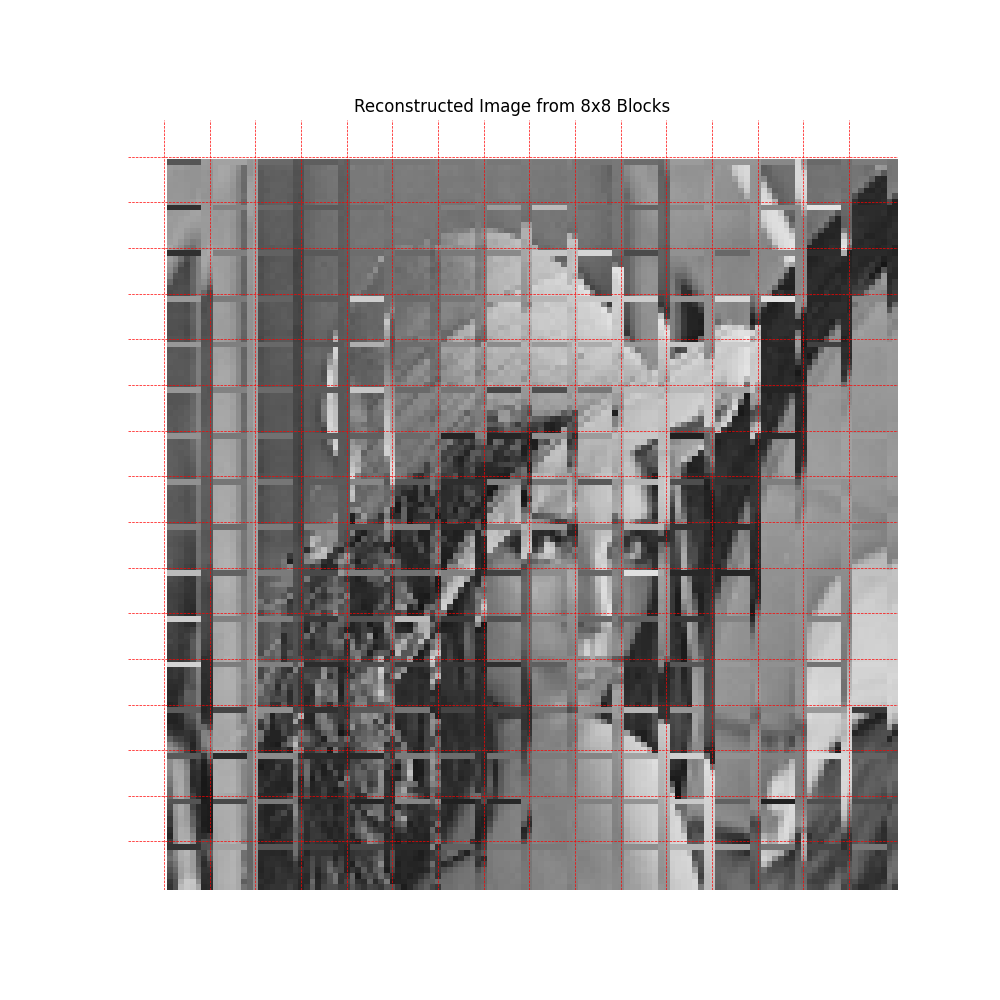

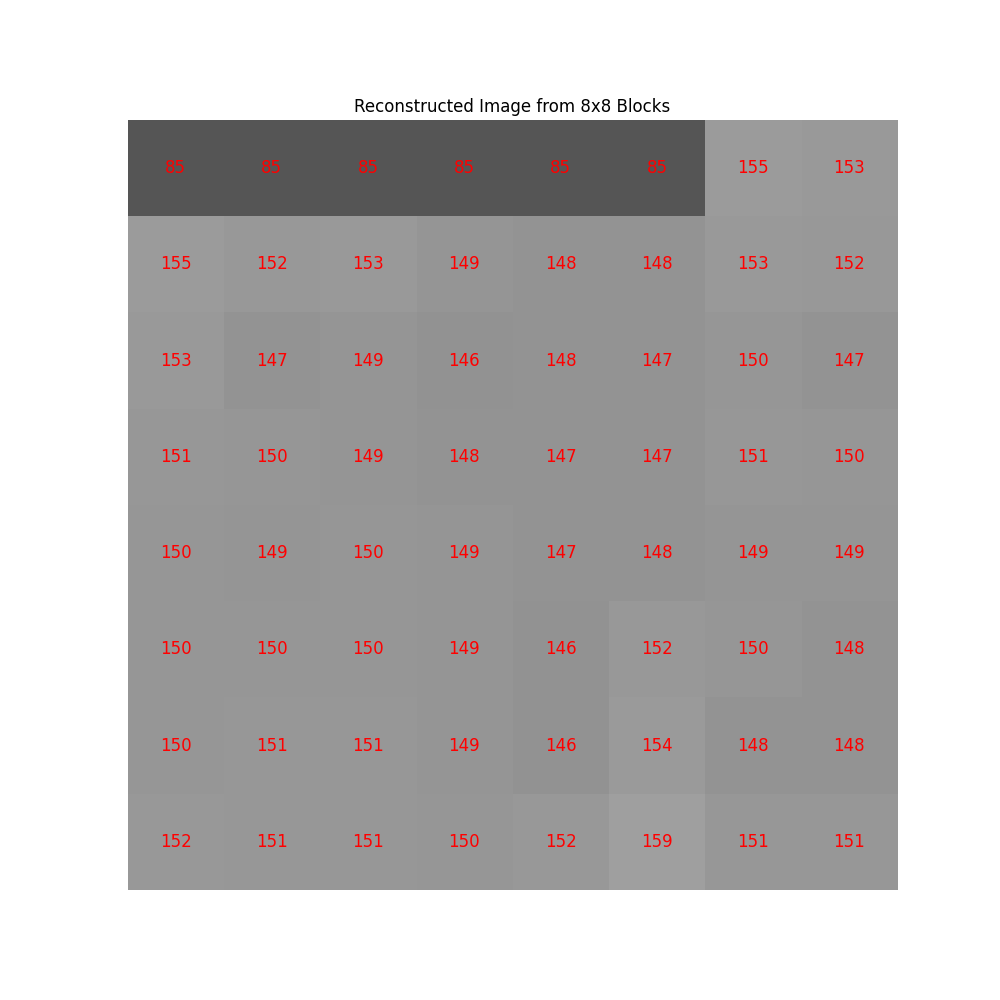

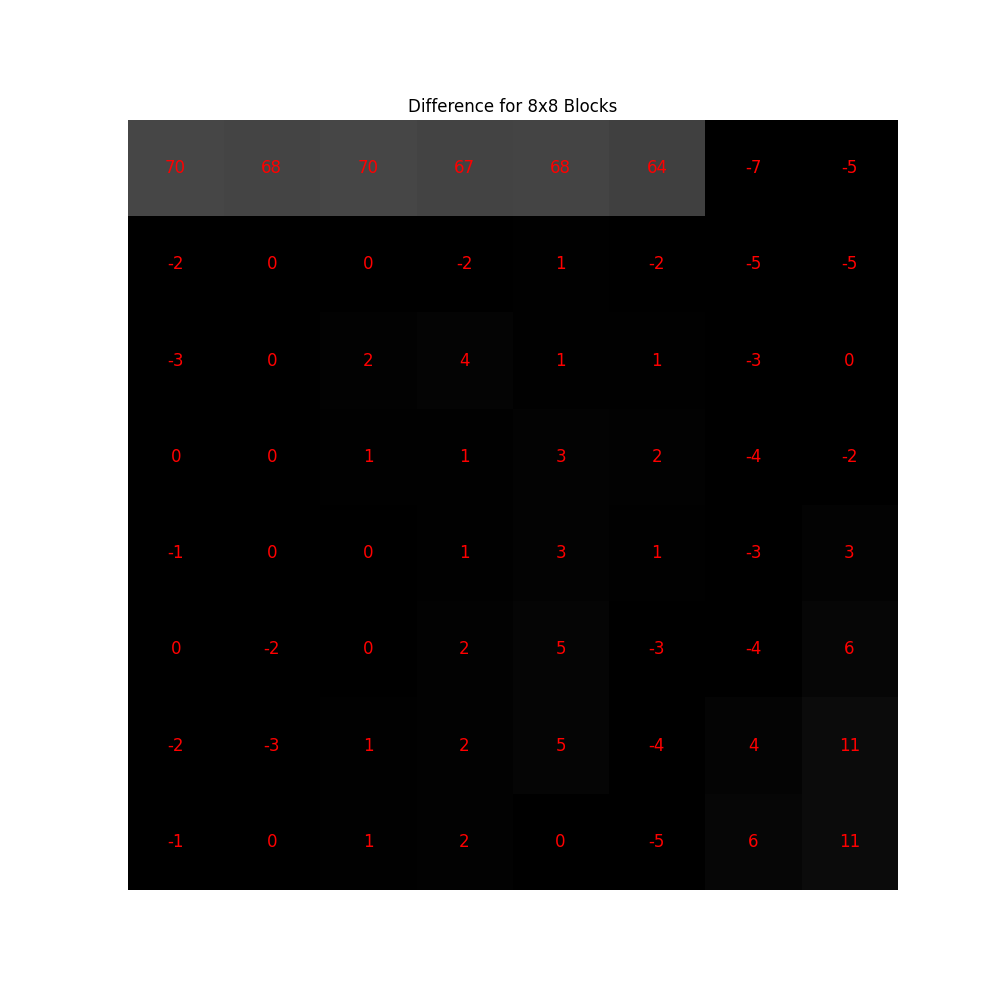

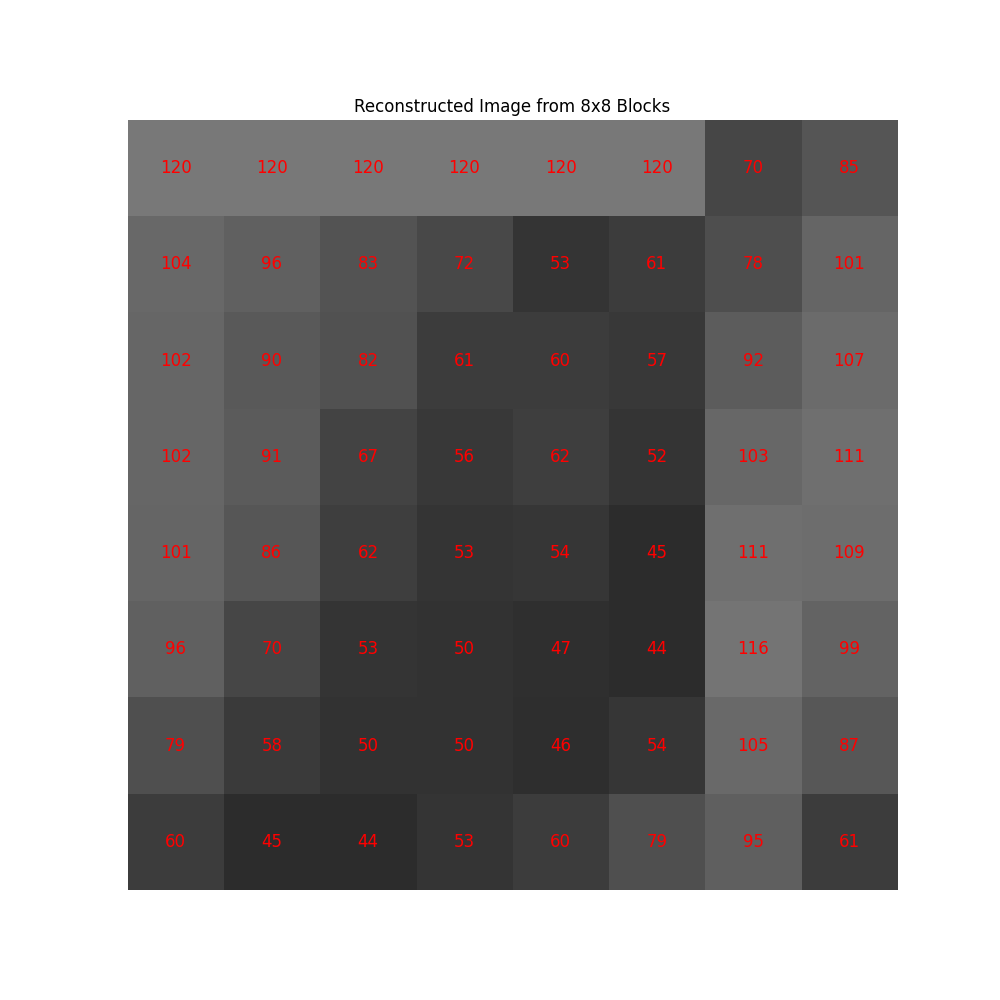

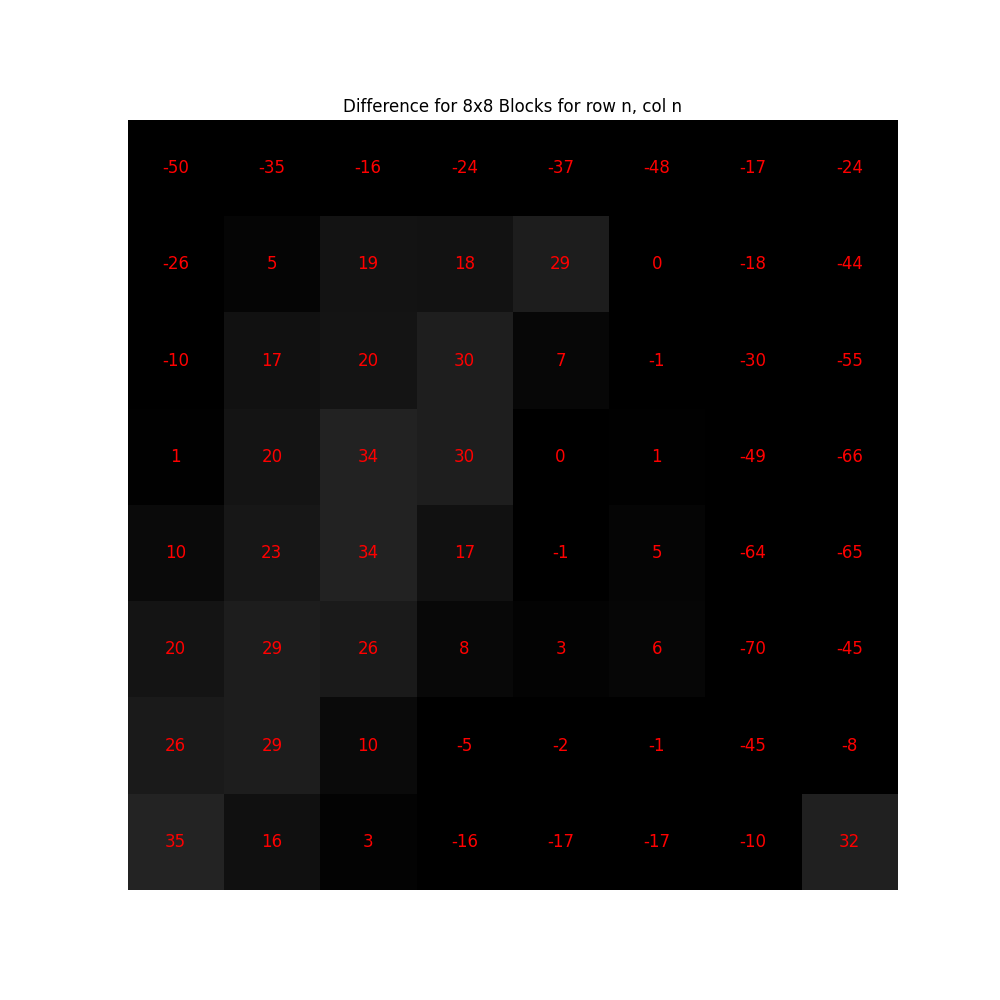

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
#draw lines on the plot to show the 8x8 blocks
for i in range(-1, 127, 8):
    plt.axhline(i, color='red', linewidth=0.5, linestyle='--')
for i in range(-1, 127, 8):
    plt.axvline(i, color='red', linewidth=0.5, linestyle='--')
plt.title("Reconstructed Image from 8x8 Blocks")
plt.axis('off')
plt.ion()
plt.show()

# np.savetxt('dct_cff.txt',reconstructed)

# plot the first block of pixel only
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed[0:8,0:8], cmap='gray', vmin=0, vmax=255)
# write pixel values on the plot on the respectiver pixels
for i in range(8):
    for j in range(8):
        plt.text(j,i,f"{int(reconstructed[i,j]):d}", ha='center', va='center', fontsize=12, color='red')
plt.title("Reconstructed Image from 8x8 Blocks")
plt.axis('off')
plt.show()

# plot difference between original and reconstructed block
plt.figure(figsize=(10, 10))
plt.imshow(ogimg[0:8,0:8]-reconstructed[0:8,0:8], cmap='gray', vmin=0, vmax=255)
# write pixel values on the plot on the respectiver pixels
for i in range(8):
    for j in range(8):
        plt.text(j,i,f"{int(ogimg[i,j]-reconstructed[i,j]):d}", ha='center', va='center', fontsize=12, color='red')
plt.title("Difference for 8x8 Blocks")
plt.axis('off')
plt.show()


# plot another block
row, col = 15, 15

plt.figure(figsize=(10, 10))
plt.imshow(reconstructed[row*8:(1+row)*8,col*8:(1+col)*8], cmap='gray', vmin=0, vmax=255)
# write pixel values on the plot on the respectiver pixels
for i in range(8):
    for j in range(8):
        plt.text(j,i,f"{int(reconstructed[row*8 + i,col*8 + j]):d}", ha='center', va='center', fontsize=12, color='red')
plt.title("Reconstructed Image from 8x8 Blocks")
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(ogimg[row*8:(1+row)*8,col*8:(1+col)*8]-reconstructed[row*8:(1+row)*8,col*8:(1+col)*8], cmap='gray', vmin=0, vmax=255)
# write pixel values on the plot on the respectiver pixels
for i in range(8):
    for j in range(8):
        plt.text(j,i,f"{int(ogimg[row*8 + i,col*8 + j]-reconstructed[row*8 + i,col*8 + j]):d}", ha='center', va='center', fontsize=12, color='red')
plt.title("Difference for 8x8 Blocks for row n, col n")
plt.axis('off')
plt.show()

In [13]:
rcvd = reconstructed

In [14]:
plt.imshow(ogimg.astype(np.float64)-rcvd + (ogimg.astype(np.float64)-rcvd).min(),cmap='gray',interpolation=None,vmin=0,vmax=255)

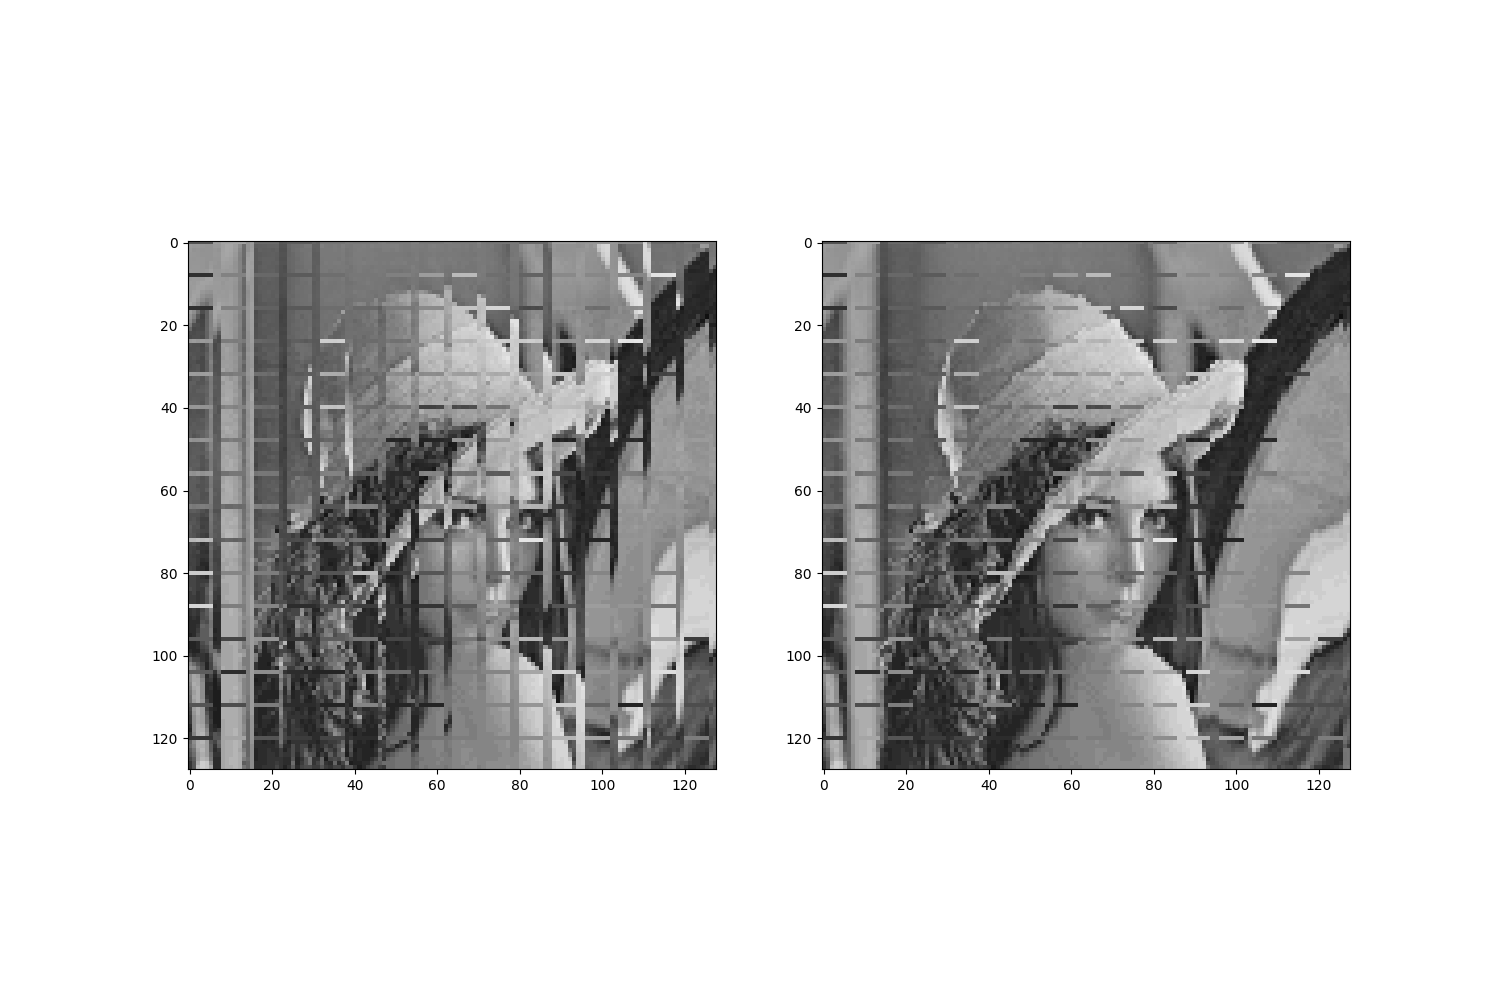

In [16]:
plt.figure(figsize=(15,10))

def circular_left_shift(img: np.ndarray) -> np.ndarray:
    # Create a copy of the image to preserve the original array
    shifted_img = img.copy()
    
    # Parameters for the blocks
    start = 6          # first block starts at column index 6
    block_width = 2    # each block is 2 columns wide
    step = 8           # the blocks are spaced 8 columns apart

    # Determine the number of blocks. For a 128-column image:
    num_blocks = (128 - start) // step  # Should be 16 blocks

    # Generate a list of slice objects for each block
    blocks = [slice(start + step * i, start + step * i + block_width) for i in range(num_blocks)]

    # Save a copy of the first block (to wrap it around at the end)
    temp = shifted_img[:, blocks[0]].copy()

    # Shift blocks left: each block takes the content of the next block
    for i in range(num_blocks - 1):
        shifted_img[:, blocks[i]] = shifted_img[:, blocks[i + 1]]

    # Place the original first block into the last block position (circular shift)
    shifted_img[:, blocks[-1]] = temp
    shifted_img[:,118:120] = img[:,126:128]
    return shifted_img

def shift_columns_126_128_up(img: np.ndarray, n: int) -> np.ndarray:
    # Copy the image
    shifted_img = img.copy()

    # Circularly shift columns 126:128 up by n rows
    shifted_img[:, 126:128] = np.roll(img[:, 126:128], -n, axis=0)

    return shifted_img

rotated_img = shift_columns_126_128_up(circular_left_shift(rcvd),5)
# rotated_img=circular_left_shift(rcvd)
# temp = rcvd[:,14:16]
# rcvd[:,14:16] = rcvd[:,6:8] 
# rcvd[:,6:8]  = temp
plt.subplot(1,2,1)
plt.imshow(rcvd,cmap='gray',interpolation=None,vmin=0,vmax=255)
plt.subplot(1,2,2)
plt.imshow(rotated_img,cmap='gray',interpolation=None,vmin=0,vmax=255)
plt.show()
np.savetxt('rotated_img.txt',rotated_img)

In [ ]:
# xx = np.array(d3).reshape((128,128))+128
# xx=ogimg
# for i in range(128):
#     for j in range(128):
#         print(int(xx[i][j]),end=' ')
#     print('\n')

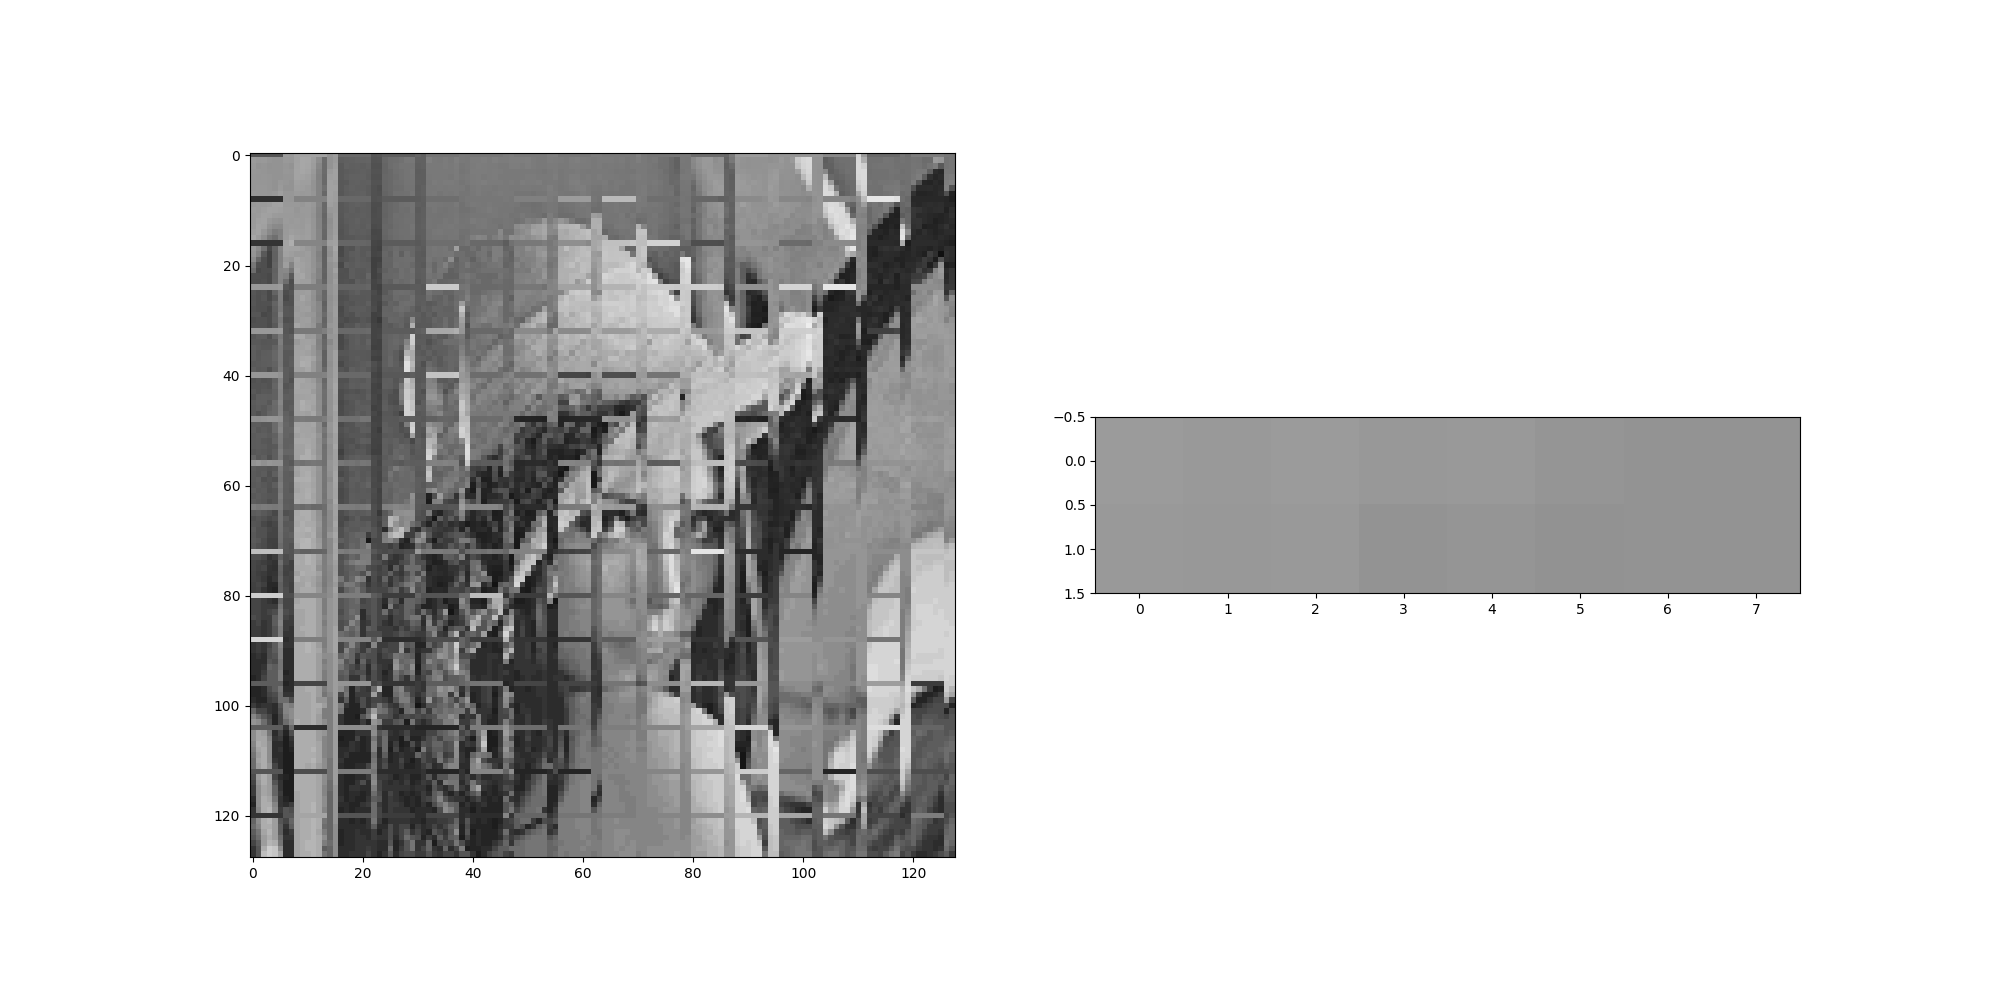

array([[155, 153, 155, 152, 153, 149, 148, 148],
       [153, 152, 153, 147, 149, 146, 148, 147]])

In [24]:
import numpy as np
import cv2

# Load the grayscale image

arr = []
with open('obtained_image.txt') as f:
    for pixel in f.readlines():
        arr.append(int(pixel))
plt.imshow(np.array(arr).reshape((128,128))[:2,:8],cmap='gray',interpolation=None,vmin=0,vmax=255)
plt.show()
np.array(arr).reshape((128,128))[:2,:8]

# Convert the img.txt to coe file

In [ ]:
def txt_to_coe(txt_filename, coe_filename, radix=10):
    try:
        with open(txt_filename, 'r') as txt_file:
            lines = [line.strip() for line in txt_file if line.strip()]

        decimal_values = [str(int(line, 2)) for line in lines]  # Convert binary to decimal

        with open(coe_filename, 'w') as coe_file:
            coe_file.write(f"memory_initialization_radix={radix};\n")
            coe_file.write("memory_initialization_vector=\n")
            
            for i, value in enumerate(decimal_values):
                if i == len(decimal_values) - 1:
                    coe_file.write(f"{value};\n")  # End with semicolon
                else:
                    coe_file.write(f"{value},\n")
        
        print(f"Successfully converted {txt_filename} to {coe_filename}")
    except Exception as e:
        print(f"Error: {e}")


# Example usage
txt_to_coe(r'Image.txt', r'output.coe')

Successfully converted Image.txt to output.coe
